In [6]:
import shap
import os
import json
import pickle as pkl
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from datasets import load_from_disk

In [21]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
SHAP_DIR = os.path.join(PROJECT_DIR, "classification/shap_values/coqa")
SPLITS_DIR = os.path.join(PROJECT_DIR, "classification/split_datasets/coqa")
MODELS_DIR = os.path.join(PROJECT_DIR, "classification/models")

In [22]:
path_to_model = os.path.join(MODELS_DIR, "distilbert-base-uncased_13091207")

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(path_to_model)
model = AutoModelForSequenceClassification.from_pretrained(path_to_model)
model.to(device)

pipe = TextClassificationPipeline(
    tokenizer=tokenizer,
    model=model,
    top_k=None, # get confidence scores for predictions
    # `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
)
pipe.device = device

In [27]:
samples = [
    "Revolving doors are convenient for two-direction travel because they allow people to enter and exit a building without having to wait for another person to open or close a regular door. However, they can also serve as a security measure because they limit the number of people who can enter or exit at one time and can prevent unauthorized access. \n\nOut of the given options, a revolving door would most likely be used as a security measure at a bank, where it is important to control access to the building and protect the safety of employees and customers. Therefore, the correct answer is A) bank.",
    "- A fast food restaurant is a common place to find hamburgers, so A is a possible answer.\n- Pizza is not related to hamburgers, so B is not a valid answer.\n- C is technically correct, as hamburgers are made from ground beef, but it is not a common or appropriate answer option.\n- D is not a location, but rather where a person eats a hamburger, so it is not a valid answer option.\n- E is not a valid answer, as it is not a location where hamburgers are typically found.\n\nTherefore, the most likely answer is A) fast food restaurant.",
    "When an enemy is approaching, animals usually feel threatened and go into a fight or flight mode. They may also try to warn each other by making noises or listening to each other's warning calls. Therefore, the correct answer is D) listen to each other.",
    "Glue sticks are commonly used for arts and crafts, as well as for bonding materials in various projects. Since adults may engage in such activities both at work and at home, it is possible that they use glue sticks in different settings. \n\nOption A mentions a classroom, indicating that adults may be teachers or educators who use glue sticks during their lessons. Option C also refers to school, which may include other settings such as a laboratory or a workshop where glue sticks can be used. \n\nOption D mentions an office, where adults may use glue sticks for various purposes such as paper crafts, scrapbooking, or labeling. Option E mentions a kitchen drawer, which may be relevant for adults who use glue sticks for DIY projects, repairs, or decorations at home.\n\nTherefore, the correct answer is: all of the above options could be correct, depending on the context and the specific adult's activities.",
    "The question states that \"He needed more information to fix it,\" implying that there was something that needed to be fixed. \n\nTo fix something, one typically needs instructions or guidance. \n\nTherefore, the answer is most likely going to be some sort of resource that provides information or instructions. \n\nOption A, chickens, is clearly not a viable option as chickens cannot provide information on how to fix things. \n\nOption B, Google, is a commonly used search engine that can provide information on just about anything, including instructions on how to fix something. This option is a likely answer. \n\nOption C, newspaper, is not a common resource for fixing things. \n\nOption D, online, is too broad of an answer and does not specify a particular resource. \n\nOption E, manual, is a common resource for fixing things, as manuals often provide instructions on how to operate and fix a particular item. This option is also a likely answer. \n\nTherefore, the answer is either B) Google or E) manual, depending on the context of the situation."
]

small_samples = [
    "When an enemy is approaching, animals usually feel threatened",
    "the answer is either B) Google or E) manual, depending on the context of the situation.",
    "the correct answer is D) listen to each other.",
    "the answer could be either A) fast food restaurant or C) school.",
    "none of the answers are correct."
]

more_samples = samples + [
    "The campaign was hoping to create a rise in awareness of the problem. So, we can eliminate options A, C, and D because they don't fit with the idea of a rise. \n\nNow, we need to consider what the campaign hoped to achieve with this rise in awareness. The word \"hopefully\" suggests that the effect was seen as positive. So, we can eliminate option B because a fall is generally not seen as positive.\n\nTherefore, the correct answer is E) reduce. The campaign was hoping to raise awareness of the problem in order to reduce its effect.",
    "Based on the options given, the most likely correct answer is either C) winch or D) construction site or E) building, as both are common places where cranes use steel cables. Without more context, it is difficult to determine the exact correct answer.",
    "James thinks of criminal justice like a computer program, which means he wants it to work efficiently and effectively. Therefore, he would not like ideas that go against this principle. \n\nA) Manual: This might not be efficient as it requires human intervention and can be prone to errors. James might not like this idea. \n\nB) Process information: This would be important for James as it would help in analyzing and making decisions based on data. He would like this idea.\n\nC) Power down: This would not be acceptable as it would mean the system is not functioning, and James wants the criminal justice system to work at all times. He would not like this idea.\n\nD) Control model: This could go either way as it depends on what type of control model it is. If it is a model that helps in making the system more efficient, James might like it. If it is a model that restricts individual rights and freedoms, he might not like it.\n\nE) Reason exists: This is important for James as he wants the criminal justice system to be based on logical and rational thinking. He would like this idea. \n\nTherefore, the ideas that James might not like are A) manual and C) power down.",
    "You want to learn to program from another person. \n\nOption A: \"Learn how to\" is not a clear answer. Learn how to what? \n\nOption B: \"Have a friend\" is not a solution. Just having a friend who knows programming doesn't necessarily mean they will teach you or have the time to do so. \n\nOption C: \"Knowledge\" is again not a solution. It's important to have knowledge, but it doesn't answer how to learn from another person. \n\nOption D: \"Take a class\" is a good option. Taking a class with a teacher or instructor can provide guidance and structured learning. \n\nOption E: \"Have a computer\" is important, but it doesn't answer how to learn from another person. \n\nTherefore, the correct answer is D) take a class.",
    "An unsmooth pit refers to the pit or seed of a fruit that is not smooth. \n\nOption A: Backyard doesn't make sense as a source for an unsmooth pit.\n\nOption B: Rocks don't have pits, so it can't be the answer.\n\nOption C: Mines also don't have pits that are relevant to this question.\n\nOption D: A cherry pit can be unsmooth, but it's not the most common example.\n\nOption E: A peach pit is the most common example of an unsmooth pit.\n\nTherefore, the answer is E) peach."
]

In [24]:
preds = pipe(samples)
small_preds = pipe(small_samples)

## Different MASKERS

In [8]:
# default masker == model's tokenizer
explainer = shap.Explainer(pipe, seed=1)
sv = explainer(small_samples)
sv

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


.values =
array([array([[ 0.        ,  0.        ],
              [-0.00941626,  0.00941625],
              [-0.02070174,  0.02070174],
              [-0.04954952,  0.04954953],
              [-0.03254303,  0.03254303],
              [ 0.01038524, -0.01038524],
              [-0.0062085 ,  0.00620849],
              [-0.02229622,  0.02229622],
              [ 0.04637151, -0.04637153],
              [-0.06071769,  0.06071769],
              [ 0.05510056, -0.05510059],
              [ 0.        ,  0.        ]]),
       array([[ 0.        ,  0.        ],
              [ 0.00744887, -0.00744886],
              [-0.12869052,  0.12869052],
              [ 0.00395193, -0.00395192],
              [ 0.18983808, -0.1898381 ],
              [ 0.03000983, -0.03000983],
              [ 0.00138047, -0.00138048],
              [-0.04825033,  0.04825032],
              [ 0.28585903, -0.285859  ],
              [ 0.15557608, -0.1555761 ],
              [ 0.00911786, -0.00911784],
              [-0.0219

In [9]:
def show_base_pred_plot(i, preds, sv, cl:[0,1]):
    base = sv.base_values[i][cl]
    for pred in preds[i]:
        if pred["label"] == 'LABEL_0':
            neg_pred = (pred["label"], round(pred["score"], 2))
        if pred["label"] == 'LABEL_1':
            pos_pred = (pred["label"], round(pred["score"], 2))
    
    print(f"Expected: {round(base, 2)}")
    print(f"Predicted: {neg_pred} - {pos_pred}")
    shap.plots.bar(sv[i, :, cl], max_display=10)

Expected: 0.72
Predicted: ('LABEL_0', 0.19) - ('LABEL_1', 0.81)


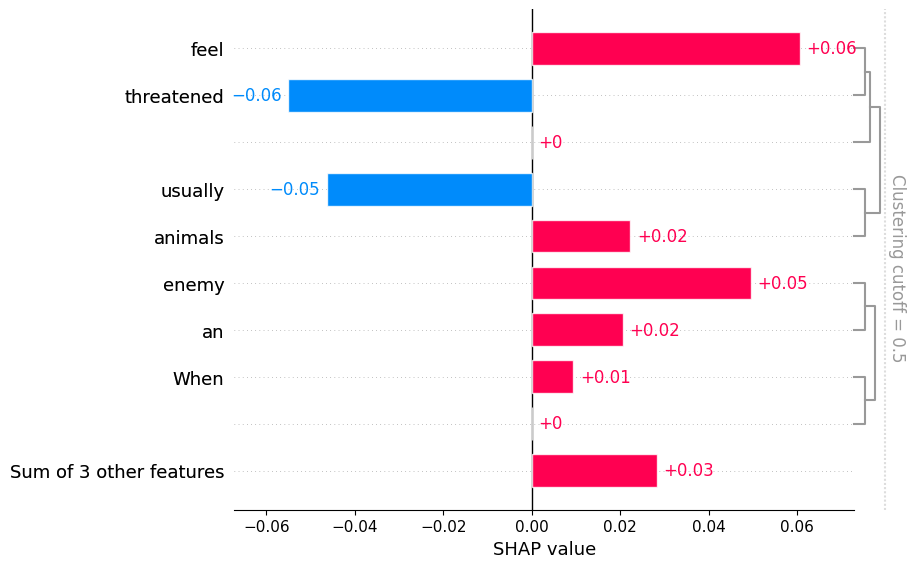

In [10]:
# 3rd sample, negative class
show_base_pred_plot(i=0, preds=small_preds, sv=sv, cl=1) # red contributed to cl

In [11]:
masker_w = shap.maskers.Text(tokenizer=r"\W+")
explainer_w = shap.Explainer(pipe, masker=masker_w, seed=1)
sv_w = explainer_w(small_samples)
sv_w

.values =
array([array([[-0.0160794 ,  0.01607939],
              [ 0.01406013, -0.01406013],
              [ 0.00156049, -0.0015605 ],
              [-0.0031126 ,  0.00311261],
              [ 0.03482726, -0.03482725],
              [-0.00897762,  0.00897762],
              [ 0.0061677 , -0.00616771],
              [-0.00911726,  0.00911725],
              [ 0.02081507, -0.02081507]]),
       array([[-2.60403519e-02,  2.60403519e-02],
              [-1.53518924e-01,  1.53518903e-01],
              [ 1.98811237e-02, -1.98811551e-02],
              [ 2.10254697e-01, -2.10254704e-01],
              [ 4.83435802e-02, -4.83435926e-02],
              [-1.65663660e-04,  1.65640959e-04],
              [ 5.63416760e-01, -5.63416750e-01],
              [-4.65644244e-03,  4.65643400e-03],
              [-2.93092737e-02,  2.93092720e-02],
              [ 9.32365349e-02, -9.32365397e-02],
              [ 8.32435144e-02, -8.32435120e-02],
              [ 2.30011325e-02, -2.30011396e-02],
          

Expected: 0.15
Predicted: ('LABEL_0', 0.98) - ('LABEL_1', 0.02)


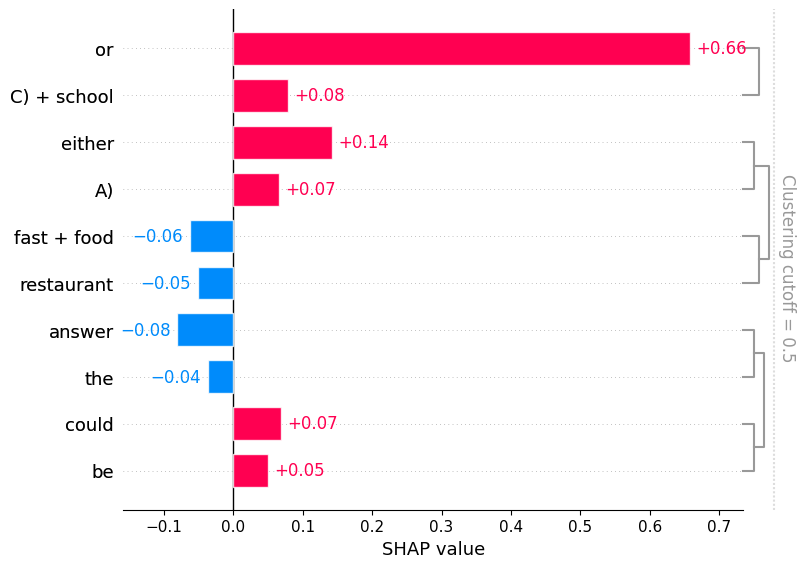

In [12]:
# 3rd sample, negative class
show_base_pred_plot(i=3, preds=small_preds, sv=sv_w, cl=0) # red contributed to cl

In [13]:
#split at period (sentence)
masker_s = shap.maskers.Text(tokenizer=r"\.", mask_token="[MASK]", collapse_mask_token=True)
explainer_s = shap.Explainer(pipe, masker=masker_s, seed=1)
sv_s = explainer_s(samples) # long text
sv_s

.values =
array([array([[ 0.00295609, -0.00295612],
              [ 0.15168855, -0.15168858],
              [ 0.04347192, -0.04347193],
              [-0.21481267,  0.21481267]]),
       array([[-0.01695303,  0.01695301],
              [-0.00601817,  0.00601815],
              [-0.00532248,  0.00532247],
              [-0.00536264,  0.00536266],
              [-0.00163926,  0.00163926],
              [-0.08452181,  0.08452182]]),
       array([[ 0.01990375, -0.01990375],
              [ 0.1478265 , -0.14782649],
              [-0.26086917,  0.26086918]]),
       array([[ 0.04255287, -0.04255285],
              [ 0.19529999, -0.19529998],
              [ 0.00272888, -0.00272889],
              [ 0.03861577, -0.03861577],
              [ 0.01559974, -0.01559977],
              [ 0.05840519, -0.0584052 ],
              [ 0.05258183, -0.05258182]]),
       array([[-0.10205824,  0.10205825],
              [ 0.01142138, -0.01142137],
              [ 0.01657508, -0.01657509],
              [ 

Expected: 0.29
Predicted: ('LABEL_0', 0.11) - ('LABEL_1', 0.89)


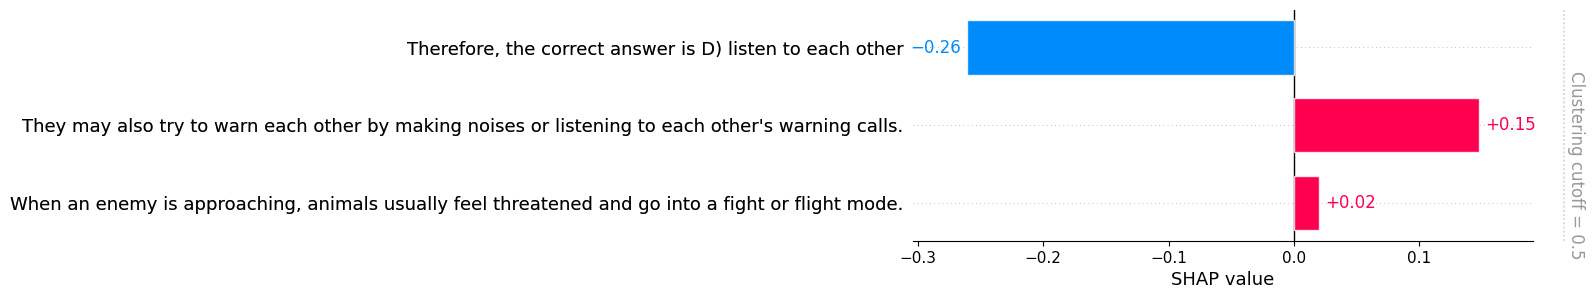

In [14]:
# 3rd sample, negative class
show_base_pred_plot(i=2, preds=small_preds, sv=sv_s, cl=0) # red contributed to cl (i.e., it is a positive contribution to the class we indicate, not to the prediction)

In [15]:
shap.plots.text(sv[0])

## SHAP sanity checks

In [16]:
# sum of all shap values must always be the same for one instance
# therefore, with ngrams, need to pad the start+end with n-1 pad tokens

l = [0.0, 0.0, 0.4, 0.6, 0.02, 0.3, 0.04, 0.8, 0.0, 0.0]

n = 3
tot = 0
for i in range(len(l)-(n-1)):
    ngram = [i for i in l[i:i+n]]
    print(ngram)
    ngram = sum(ngram) / n
    tot += ngram
    print(ngram, '\n')

tot == sum(l)

[0.0, 0.0, 0.4]
0.13333333333333333 

[0.0, 0.4, 0.6]
0.3333333333333333 

[0.4, 0.6, 0.02]
0.34 

[0.6, 0.02, 0.3]
0.30666666666666664 

[0.02, 0.3, 0.04]
0.12 

[0.3, 0.04, 0.8]
0.38000000000000006 

[0.04, 0.8, 0.0]
0.28 

[0.8, 0.0, 0.0]
0.26666666666666666 



True

In [17]:
# For any instance, the sum of the shap values = y_pred - y_avg

i = 3
pred_label = int(small_preds[i][0]['label'].split('_')[1])
pred_score = small_preds[i][0]['score']
shap_sum = [float(i) for i in np.sum(sv.values[i], axis=0)]
base = [float(i) for i in sv.base_values[i]]
print("Pred class for instance: ", pred_label)
print("Pred score for instance: ", pred_score)
print("Base values: ", base)
print("Sum of shap values: ", shap_sum)

shap_sum[pred_label] == pred_score - base[pred_label]

Pred class for instance:  0
Pred score for instance:  0.9833374619483948
Base values:  [0.3137805461883545, 0.6862194538116455]
Sum of shap values:  [0.6695569157600403, -0.669556962326169]


True

In [18]:
# base values theoretically should be the same for all instances (or not vary by a lot)
# in the case of small samples, since they are very different from the training data, we see variation
# for samples (from og data), the base values are the same

# longer text
SV_w = explainer_w(samples)
SV_w.base_values

Partition explainer: 6it [00:13,  6.98s/it]               


array([[0.1532215 , 0.84677851],
       [0.1532215 , 0.84677851],
       [0.1532215 , 0.84677851],
       [0.1532215 , 0.84677851],
       [0.1532215 , 0.84677851]])

In [29]:
# experimenting with different maskers
    # '' [0.41945168, 0.58054835]
    # '[MASK]' [0.28819373, 0.7118063 ]

masker_x = shap.maskers.Text(tokenizer=r"\W+", collapse_mask_token=True)
masker_x.mask_token = '[MASK]'
explainer_x = shap.Explainer(pipe, masker=masker_x, seed=1) # seed does not inlfuence base values
sv_x = explainer_x(small_samples)
sv_x

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


.values =
array([array([[-0.00946383,  0.00946383],
              [-0.01362845,  0.01362842],
              [-0.06566209,  0.06566209],
              [-0.05428437,  0.05428437],
              [ 0.03425994, -0.03425994],
              [-0.04985947,  0.04985949],
              [ 0.04676263, -0.04676265],
              [-0.03745531,  0.03745531],
              [ 0.0545025 , -0.0545025 ]]),
       array([[ 0.00193583, -0.00193582],
              [-0.12182587,  0.12182586],
              [-0.0131117 ,  0.0131117 ],
              [ 0.41545802, -0.41545802],
              [-0.04896955,  0.04896958],
              [-0.05838519,  0.05838517],
              [ 0.41189319, -0.41189323],
              [-0.05306838,  0.05306837],
              [-0.00415174,  0.00415172],
              [ 0.11913219, -0.11913218],
              [ 0.06631042, -0.06631042],
              [ 0.00955181, -0.00955183],
              [-0.03172207,  0.03172207],
              [ 0.03060425, -0.03060425],
              [ 0.0137

## Understanding model's behaviour

#### when no specific information is provided (all tokens masked out)

Same as shap base values when using a particular mask token

Choices that make sense: [MASK] and empty string

    # '' [0.41945168, 0.58054835]
    # '...' [0.15069047, 0.8493095 ]
    # '[MASK]' [0.28819373, 0.7118063 ]

In [33]:
pipe('[MASK]')

[[{'label': 'LABEL_1', 'score': 0.7118062973022461},
  {'label': 'LABEL_0', 'score': 0.2881937325000763}]]

In [34]:
pipe('...')

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[[{'label': 'LABEL_1', 'score': 0.8467785120010376},
  {'label': 'LABEL_0', 'score': 0.1532215029001236}]]

In [35]:
pipe('')

[[{'label': 'LABEL_1', 'score': 0.5805483460426331},
  {'label': 'LABEL_0', 'score': 0.41945168375968933}]]

In [19]:
dataset = load_from_disk(os.path.join(PROJECT_DIR, "classification/split_datasets/coqa"))

# check the label distribution in each set
from collections import Counter

distr_train = dict(Counter(dataset['train']['label']))
distr_val = dict(Counter(dataset['validation']['label']))
distr_test = dict(Counter(dataset['test']['label']))

for distr in [distr_train, distr_val, distr_test]:
    label_1_count = distr[True]
    label_0_count = distr[False]
    label_1_perc = round(label_1_count / (label_1_count + label_0_count), 2)
    label_0_perc = round(label_0_count / (label_1_count + label_0_count), 2)
    print(distr, "-", label_1_perc, "/", label_0_perc)

{True: 4934, False: 3066} - 0.62 / 0.38
{True: 606, False: 394} - 0.61 / 0.39
{True: 622, False: 378} - 0.62 / 0.38
